In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

# Section 1: Quick data exploration and preparation

In [2]:
df_raw = pd.read_csv('https://raw.githubusercontent.com/sivanyo/ML-HW3/main/variant_labeled.csv')
df_raw

,ID,AgeGroup,BMI,BloodType,ConversatiosPerDay,DisciplineScore,HappinessScore,HouseholdExpenseOnPresents,HouseholdExpenseOnSocialGames,HouseholdExpenseParkingTicketsPerYear,MedicalCarePerYear,NrCousins,PCR_10,PCR_17,PCR_19,PCR_32,PCR_45,PCR_46,PCR_7,PCR_72,PCR_76,PCR_8,PCR_83,PCR_89,PCR_9,PCR_93,PCR_95,Sex,SocialActivitiesPerDay,SocialMediaPerDay,SportsPerDay,StepsPerYear,StudingPerDay,VariantScore
0,4615,4.0,15.75,B+,14.0,60.0,6.0,1325.72,496.17,911.74,27.0,4.0,1.799896,1.444451,NaN,-1.571850,0.801410,1.917945,1.690213,-0.171748,-1.523529,-0.306861,0.565910,0.438831,1.367438,-2.249516,2.218356,F,84.97,70.48,42.48,4.0,9.1,0.425317
1,1680,7.0,20.11,AB-,9.0,6.0,4.0,645.69,695.10,496.95,29.0,7.0,0.868056,-0.307865,0.653187,0.798339,-0.593106,-0.988938,-0.222645,-0.046236,0.356250,-0.609497,-0.483010,NaN,NaN,NaN,2.049281,M,NaN,127.93,52.20,7.0,4.9,0.571545
2,8866,5.0,19.44,NaN,11.0,4.0,5.0,1010.76,381.79,223.02,19.0,5.0,2.170466,1.061738,1.024312,-0.913777,1.737937,1.216280,-0.181298,0.334038,1.968806,0.718268,1.666072,5.971252,0.828838,0.488605,3.330753,M,73.88,143.13,36.94,5.0,NaN,0.629826
3,7525,5.0,24.57,AB-,13.0,7.0,5.0,1214.76,565.30,501.88,37.0,5.0,NaN,1.227796,-3.617988,NaN,2.537677,1.491512,-0.385241,0.541629,3.384428,1.107271,2.475159,2.229985,0.379172,1.232192,-1.624955,M,92.58,188.29,46.29,5.0,NaN,0.795983
4,5389,1.0,19.30,B-,14.0,7.0,6.0,1393.30,273.82,78.91,33.0,1.0,1.334839,2.626946,-0.512107,-0.429517,1.132747,0.596860,0.225130,NaN,1.634172,2.799492,1.115116,8.482129,0.070619,NaN,0.288845,M,62.97,104.86,31.48,1.0,0.8,0.522616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,5990,7.0,14.97,B-,11.0,5.0,NaN,983.31,NaN,434.72,21.0,7.0,NaN,-0.253909,-0.270558,-0.919249,1.064866,1.169131,NaN,0.972605,0.446860,NaN,0.957624,-1.087838,2.020739,NaN,2.679240,F,49.16,47.66,24.58,7.0,4.3,0.399925
3996,1692,3.0,18.19,AB-,4.0,7.0,2.0,0.00,421.28,387.49,35.0,3.0,2.454104,0.686208,-0.333063,0.293203,NaN,-0.444101,1.469979,-1.048626,-2.148641,-1.193288,NaN,-0.608159,0.863015,-1.111373,4.238641,M,77.75,74.12,38.87,3.0,3.7,0.882143
3997,9645,3.0,20.87,O-,NaN,5.0,8.0,2306.34,749.77,828.14,22.0,3.0,NaN,-0.062680,2.179080,-0.072817,0.046779,0.089618,0.653738,1.059357,-0.048917,-0.375866,0.036363,0.590578,1.296997,-0.090578,1.167840,F,110.02,142.88,55.01,3.0,8.3,0.573354
3998,11577,NaN,NaN,O+,10.0,6.0,4.0,889.36,658.45,0.00,29.0,NaN,0.674347,-0.922378,0.516568,1.877120,-1.784768,-2.356349,-0.992826,-0.668789,-0.037991,-0.947073,-1.545852,-0.057274,-0.391903,1.517528,2.548608,M,100.52,96.73,50.26,NaN,0.1,0.522282


**Q1**

In [3]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_raw, test_size=0.2, random_state=12)

# we are going to modify slices of dataset so pandas see it as 'SettingWithCopyWarning'. those msg are not relevant and annoying so...
pd.options.mode.chained_assignment = None  # default='warn'

**Q2**

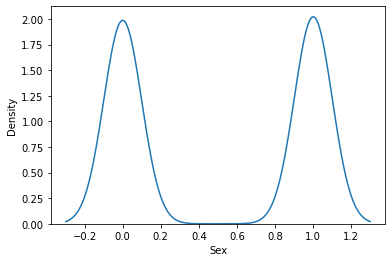

In [4]:
# dont know what to do - sex is categorial 
tmp = train.Sex.apply(lambda x: 1 if x=='M' else 0)  # we know there are no NaN vals in this col
sns.kdeplot(data=tmp)

**Q3**

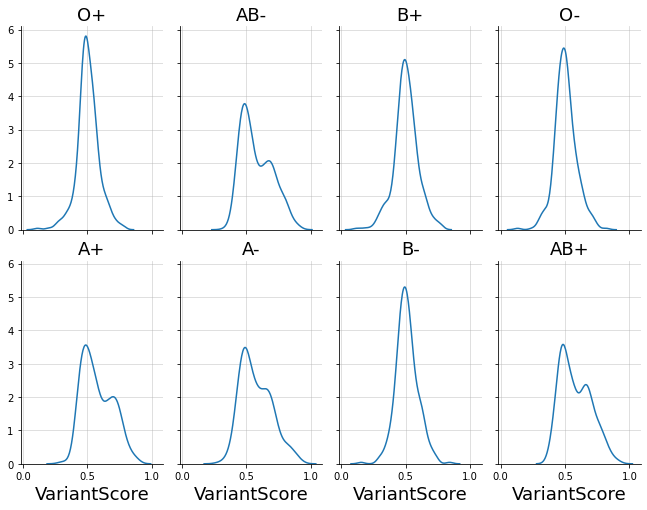

In [5]:
g = sns.FacetGrid(train, col="BloodType", height=3.5, aspect=.65, col_wrap=4)
g.map(sns.kdeplot, "VariantScore")
g.set_titles(col_template="{col_name}", size=18)
g.set_xlabels(size=18)
for ax in g.axes:
 ax.grid(alpha=0.5)

# Preprocessing (data preparation)


In [6]:
def category_to_numeric(df):
  normal_dist = ['O+', 'O-', 'B+', 'B-']
  df['BloodType'] = df.BloodType.astype(str)
  df['BloodType'] = df['BloodType'].apply(lambda x : 0 if x in normal_dist else 1)
  df['BloodType'] = df.BloodType.astype(float)
  df['Sex'] = df['Sex'].apply(lambda x : 1 if x=='M' else 0)

category_to_numeric(train)
category_to_numeric(test)

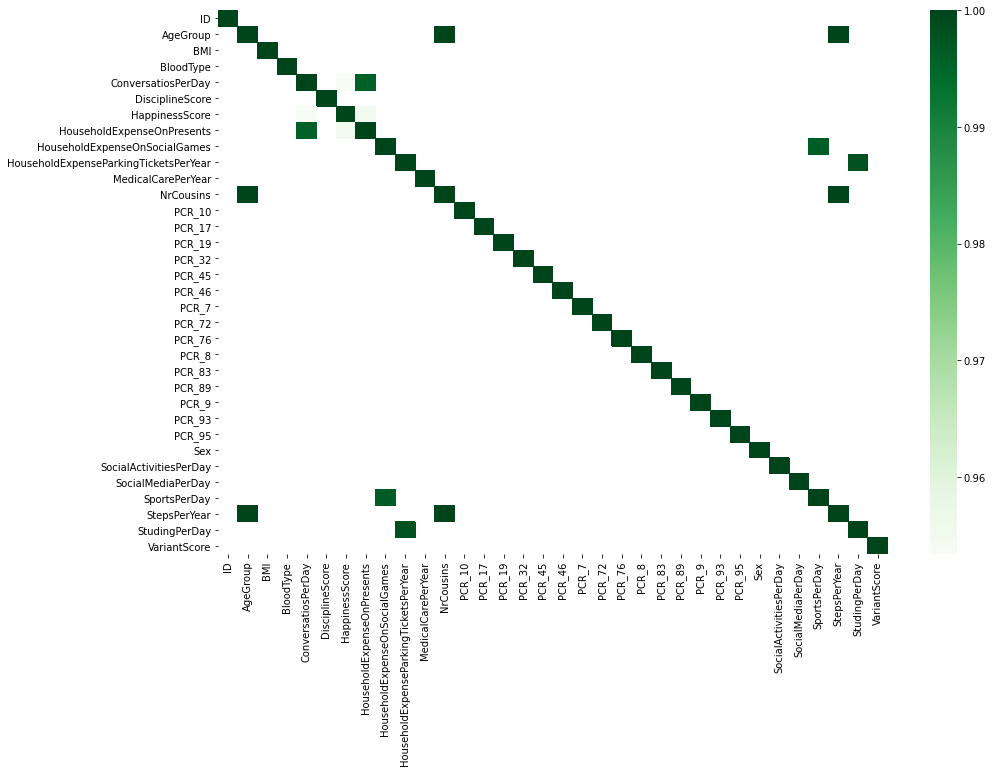

In [7]:
train.corr()
corr = train.corr()
kot = corr[corr>=.9]
plt.figure(figsize=(15,10))
sns.heatmap(kot, cmap="Greens")
plt.show()

In [8]:
def remove_corr_feat(df):
  df.drop('NrCousins', axis=1, inplace=True)
  df.drop('StepsPerYear', axis=1, inplace=True)
  df.drop('HouseholdExpenseParkingTicketsPerYear', axis=1, inplace=True)
  df.drop('HouseholdExpenseOnSocialGames', axis=1, inplace=True)
  # df.drop('HouseholdExpenseOnPresents', axis=1, inplace=True)

remove_corr_feat(train)
remove_corr_feat(test)

In [9]:
# this df will use us for the data preparation of the final test
ppt = pd.DataFrame(columns = ['mean', 'median', 'max', 'min', 'high outlier', 'low outlier'])
for col in train.columns.to_list()[1:-1]:
  ppt.loc[col] = [train[col].mean(),train[col].median(),0,0,0,0]
# ppt

In [10]:
# outliers and fillna

alpha_all = 3.5
alpha_for_pcr = 5

for col in train.columns.to_list()[1:-1]:
  q1 = train[col].quantile(0.25)
  q3 = train[col].quantile(0.75)
  iqr = q3-q1 
  current_alpha = alpha_all
  if 'PCR_' in col:
    current_alpha = alpha_for_pcr
  fence_low  = q1-current_alpha*iqr
  if 'PCR_' not in col and fence_low < 0:
    fence_low = 0
  fence_high = q3+current_alpha*iqr
  ppt.at[col, 'low outlier'] = fence_low
  ppt.at[col, 'high outlier'] = fence_high

ppt.at['AgeGroup', 'low outlier'] = 0  # manually set this 3 cols
ppt.at['AgeGroup', 'high outlier'] = 9
ppt.at['HappinessScore', 'low outlier'] = 1
ppt.at['HappinessScore', 'high outlier'] = 10
ppt.at['DisciplineScore', 'low outlier'] = 1
ppt.at['DisciplineScore', 'high outlier'] = 10


def fill_outliers(df):
  for col in train.columns.to_list()[1:-1]:
    m = ppt.at[col, 'median']
    fence_low = ppt.at[col, 'low outlier']
    fence_high = ppt.at[col, 'high outlier']
    df[col] = df[col].apply(lambda row: m if (pd.isnull(row) or row < fence_low or row > fence_high) else row)


fill_outliers(train)
fill_outliers(test)

In [11]:
#normalization
for col in train.columns.to_list()[1:-1]:
  ppt.at[col, 'max'] = train[col].max()
  ppt.at[col, 'min'] = train[col].min()


def normalize(df):
  for col in train.columns[1:-1]:
    min = ppt.at[col, 'min']
    max = ppt.at[col, 'max']
    df[col] =  df[col].apply(lambda row: (row-min)/(max-min))


normalize(train)
normalize(test)

In [12]:
def preprocessing_data(df):
  category_to_numeric(df)
  remove_corr_feat(df)
  fill_outliers(df)
  normalize(df)

  
ppt

,mean,median,max,min,high outlier,low outlier
AgeGroup,4.734311,5.000000,9.000000,0.000000,9.000000,0.000000
BMI,21.992280,19.610000,25.700000,13.330000,29.311250,9.931250
BloodType,0.545000,1.000000,1.000000,0.000000,4.500000,0.000000
ConversatiosPerDay,12.643379,13.000000,25.000000,0.000000,32.500000,0.000000
DisciplineScore,5.810820,5.000000,10.000000,1.000000,10.000000,1.000000
HappinessScore,5.301571,5.000000,10.000000,1.000000,10.000000,1.000000
HouseholdExpenseOnPresents,1200.606471,1186.825000,3013.920000,0.000000,3913.821250,0.000000
MedicalCarePerYear,25.892536,26.000000,52.000000,3.000000,66.000000,0.000000
PCR_10,12.832753,1.260134,8.166143,-2.552057,8.277083,-5.805121
PCR_17,6.443575,0.170190,8.770000,-2.512492,8.897190,-8.462466


In [13]:
print(train.columns)
train

Index(['ID', 'AgeGroup', 'BMI', 'BloodType', 'ConversatiosPerDay',
       'DisciplineScore', 'HappinessScore', 'HouseholdExpenseOnPresents',
       'MedicalCarePerYear', 'PCR_10', 'PCR_17', 'PCR_19', 'PCR_32', 'PCR_45',
       'PCR_46', 'PCR_7', 'PCR_72', 'PCR_76', 'PCR_8', 'PCR_83', 'PCR_89',
       'PCR_9', 'PCR_93', 'PCR_95', 'Sex', 'SocialActivitiesPerDay',
       'SocialMediaPerDay', 'SportsPerDay', 'StudingPerDay', 'VariantScore'],
      dtype='object')


,ID,AgeGroup,BMI,BloodType,ConversatiosPerDay,DisciplineScore,HappinessScore,HouseholdExpenseOnPresents,MedicalCarePerYear,PCR_10,PCR_17,PCR_19,PCR_32,PCR_45,PCR_46,PCR_7,PCR_72,PCR_76,PCR_8,PCR_83,PCR_89,PCR_9,PCR_93,PCR_95,Sex,SocialActivitiesPerDay,SocialMediaPerDay,SportsPerDay,StudingPerDay,VariantScore
3655,12503,0.555556,0.334681,0.0,0.68,0.333333,0.666667,0.596220,0.306122,0.437285,0.295305,0.627460,0.374012,0.577396,0.635908,0.473646,0.340479,0.736045,0.324188,0.658713,0.458128,0.327803,0.574068,0.606723,1.0,0.571810,0.236314,0.504876,0.400000,0.479114
1251,11511,0.555556,0.458367,1.0,0.76,0.333333,0.666667,0.712537,0.346939,0.355675,0.229622,0.435006,0.725517,0.281992,0.276439,0.670758,0.558339,0.634474,0.111858,0.330305,0.226643,0.615045,0.804344,0.739404,1.0,0.254375,0.466132,0.254375,0.491667,0.606691
1699,10251,0.666667,0.640259,0.0,0.36,0.333333,0.333333,0.393781,0.306122,0.465733,0.239003,0.441072,0.347690,0.540982,0.653557,0.596254,0.365049,0.558798,0.164601,0.548107,0.250662,0.446923,0.471669,0.717755,0.0,0.509285,0.629622,0.494589,0.708333,0.449764
457,11080,0.777778,0.507680,1.0,0.52,0.444444,0.666667,0.538777,0.448980,0.324723,0.237774,0.744662,0.391732,0.478820,0.607255,0.491686,0.374341,0.633650,0.158677,0.488544,0.125967,0.353391,0.466795,0.533405,1.0,0.463260,0.517472,0.463193,0.491667,0.551932
3832,14781,0.666667,0.391269,0.0,0.60,0.555556,0.555556,0.488908,0.510204,0.373463,0.215616,0.308720,0.726317,0.282646,0.275729,0.438292,0.407444,0.636392,0.250318,0.588192,0.225656,0.297263,0.806691,0.614600,0.0,0.826319,0.466132,0.826319,0.491667,0.454876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3313,11085,0.333333,0.368634,1.0,0.92,0.444444,0.888889,0.879356,0.387755,0.510014,0.206116,0.438091,0.422422,0.363293,0.569699,0.591732,0.733349,0.388951,0.071919,0.369857,0.257113,0.751272,0.364812,0.533223,1.0,0.574415,0.344238,0.574349,0.941667,0.534842
3325,451,0.555556,0.507680,1.0,0.52,0.333333,0.444444,0.310911,0.469388,0.355675,0.116636,0.735224,0.461763,0.502841,0.542634,0.559652,0.433216,0.640180,0.155038,0.525160,0.136906,0.395932,0.626792,0.529661,0.0,0.364195,0.295989,0.364195,0.641667,0.524035
1414,1496,0.666667,0.561035,1.0,0.48,0.333333,0.444444,0.393781,0.326531,0.266838,0.237774,0.329833,0.394457,0.473653,0.604294,0.432565,0.251554,0.516617,0.267067,0.588192,0.223800,0.253888,0.464690,0.424095,1.0,0.453908,0.466132,0.453841,0.833333,0.721883
1691,8908,0.666667,0.547292,0.0,0.52,0.666667,0.444444,0.388902,0.632653,0.414624,0.295652,0.426688,0.373146,0.522399,0.583394,0.694021,0.133315,0.633650,0.257280,0.539583,0.247714,0.246806,0.578135,0.533223,0.0,0.642351,0.405283,0.504876,0.275000,0.500270


# Section 2: Evaluation


In [14]:
errors_data = pd.DataFrame(columns= ['section', 'Train MSE', 'Validation MSE'])
errors_data.loc['Dummy'] = [2, 0, 0]
errors_data.loc['Basic Linear'] = [3, 0, 0]
errors_data.loc['Multilevel linear'] = [4, 0, 0]
errors_data.loc['Multilevel poly'] = [5, 0, 0]

In [15]:
attributes = train.columns.to_list()
features = attributes[1:-1]

**Q6**

In [16]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error, make_scorer

def CV_evaluation(h, X_train, y_train, n_splits=5):
  scores = cross_validate(h, X_train, y_train, cv=n_splits,
  scoring=make_scorer(mean_squared_error),
  return_train_score=True)
  
  train_mse = scores['train_score'].mean()
  valid_mse = scores['test_score'].mean()
  
  return (train_mse, valid_mse)

**Q7**

In [17]:
from sklearn.dummy import DummyRegressor

dummy_regressor = DummyRegressor(strategy="mean")
# dummy_regressor.fit(train)

x,y = CV_evaluation(dummy_regressor, train[features], train['VariantScore'])
errors_data.loc['Dummy']['Train MSE'] = x
errors_data.loc['Dummy']['Validation MSE'] = y

errors_data

,section,Train MSE,Validation MSE
Dummy,2,0.0121805,0.01219
Basic Linear,3,0,0
Multilevel linear,4,0,0
Multilevel poly,5,0,0


# Section 3: Basic linear regression

**Q8**

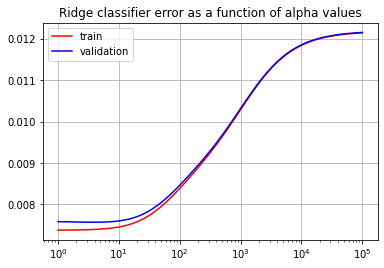

In [18]:
from sklearn.linear_model import Ridge
from matplotlib.pyplot import semilogx

def tuning(data, features_list, print_flag=True):
  train_scores, validation_scores = [], []
  alpha_values = np.logspace(0, 5, num=100)
  best_score_on_train, best_score_on_validation, best_alpha = 1, 1, 0
  for val in alpha_values:
    ridge = Ridge(val)
    error = CV_evaluation(ridge, data[features_list], data['VariantScore'])
    train_scores.append(error[0])
    validation_scores.append(error[1])
    if error[1] < best_score_on_validation:
      best_score_on_validation = error[1]
      best_score_on_train = error[0]
      best_alpha = val
  
  if print_flag:
    plt.semilogx(alpha_values, train_scores, 'r', label='train')
    plt.semilogx(alpha_values, validation_scores, 'b', label='validation')
    plt.legend()
    plt.grid(True)
    plt.title("Ridge classifier error as a function of alpha values")
    plt.show()

  return best_score_on_train, best_score_on_validation, best_alpha

best_score_on_train, best_score_on_validation, best_alpha = tuning(train, features_list=features) # got (0,0) means there is no regularization at all

#  make sure this is the right plot + scores

**Q9**

In [19]:
errors_data.loc['Basic Linear']['Train MSE'] = best_score_on_train
errors_data.loc['Basic Linear']['Validation MSE'] = best_score_on_validation

errors_data

,section,Train MSE,Validation MSE
Dummy,2,0.0121805,0.01219
Basic Linear,3,0.00739167,0.00756576
Multilevel linear,4,0,0
Multilevel poly,5,0,0


**Q10**

4.0370172585965545
w =  [-1.12581615e-02 -2.21191846e-03  6.15830469e-02 -1.77666439e-02
  1.12089201e-02 -2.02157982e-02  5.40348204e-04 -9.17061652e-03
  7.55056716e-02  7.95658711e-02 -1.09494714e-01 -5.97422825e-03
  1.55639609e-04  1.93472179e-03  8.94840756e-02 -2.27657238e-01
  9.82316108e-03 -9.98311708e-03 -4.48129732e-03 -2.23968185e-02
 -9.60426154e-02 -1.22870303e-03  7.33548653e-02  8.06308030e-02
 -1.73605912e-02  1.31288515e-03  1.65686907e-02  3.14387062e-04]


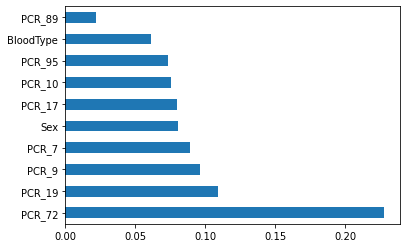

In [20]:
print(best_alpha)
ridge = Ridge(best_alpha)
ridge.fit(train[features], train['VariantScore'])
print('w = ',ridge.coef_)
# pd.Series(ridge.coef_, index = features).nlargest(10).plot(kind='barh')

tmp = pd.Series(ridge.coef_, index = features)
tmp = tmp.apply(lambda x: x if x>0 else -x)
tmp = tmp.sort_values(axis=0)
tmp.nlargest(10).plot(kind='barh')


# Section 4: Hierarchical linear regression

**Q11**

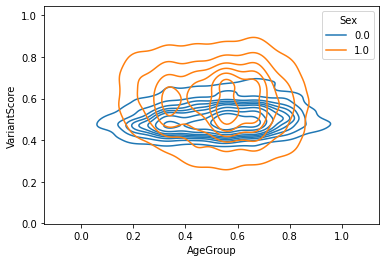

In [21]:
sns.kdeplot(data = train, x='AgeGroup', y='VariantScore', hue='Sex', color='b')

now we will split the trainig set to feamles and males

In [22]:
females = train[train['Sex'] == 0]
males = train[train['Sex'] == 1]

**Q12**

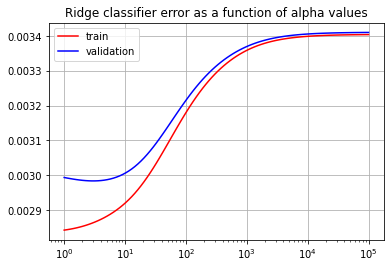

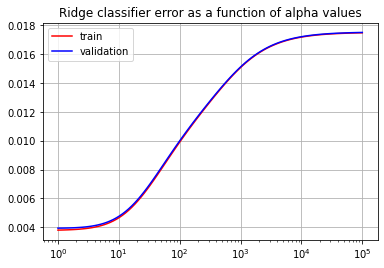

,Train MSE,Validation MSE,Best alpha
Females,0.0028616,0.00298339,2.84804
Males,0.00379825,0.00393541,1


In [23]:
SexDataFrame = pd.DataFrame(columns= ['Train MSE', 'Validation MSE', 'Best alpha'])
SexDataFrame.loc['Females'] = [0,0,0]
SexDataFrame.loc['Males'] = [0,0,0]

SexDataFrame.loc['Females']['Train MSE'], SexDataFrame.loc['Females']['Validation MSE'], SexDataFrame.loc['Females']['Best alpha'] = tuning(females, features)

SexDataFrame.loc['Males']['Train MSE'], SexDataFrame.loc['Males']['Validation MSE'], SexDataFrame.loc['Males']['Best alpha'] = tuning(males, features)

SexDataFrame

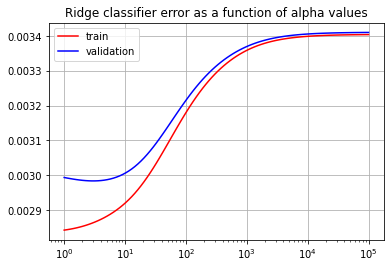

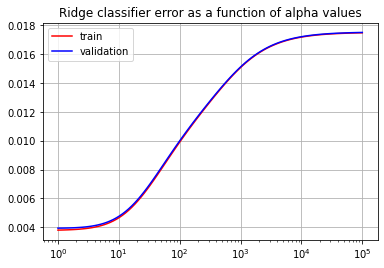

In [24]:
best_score_on_train_f, best_score_on_validation_f, best_alpha_f = tuning(train[train['Sex'] == 0], features)
best_score_on_train_m, best_score_on_validation_m, best_alpha_m = tuning(train[train['Sex'] == 1], features)

In [25]:
from sklearn.base import BaseEstimator, RegressorMixin
class MultiRegressor(BaseEstimator, RegressorMixin):
  def __init__(self, h_male, h_female):
    self.h_male = h_male
    self.h_female = h_female

  def fit(self, X, y):
    x_m = X[X['Sex'] == 1]
    y_m = y[x_m.index]
    x_m = x_m.drop(['Sex'], axis = 1)
    self.h_male.fit(x_m, y_m)

    x_f = X[X['Sex'] == 0]
    y_f = y[x_f.index]
    x_f = x_f.drop(['Sex'], axis = 1)
    self.h_female.fit(x_f, y_f)
    return self

  def predict(self, X):
    # X should be a pandas dataframe
    all_predictions = []

    for index, x in X.iterrows():
      fixed_x = x.drop(['Sex'])
      y_pred = self.h_female.predict([fixed_x]) if x['Sex'] == 0 else self.h_male.predict([fixed_x])
      all_predictions.append(y_pred[0])

    return all_predictions

In [26]:
multi = MultiRegressor(Ridge(best_alpha_m), Ridge(best_alpha_f))

**Q13**

In [27]:
errors = CV_evaluation(multi, train[features], train['VariantScore'])

errors_data.loc['Multilevel linear']['Train MSE'] = errors[0]
errors_data.loc['Multilevel linear']['Validation MSE'] = errors[1]

errors_data

,section,Train MSE,Validation MSE
Dummy,2,0.0121805,0.01219
Basic Linear,3,0.00739167,0.00756576
Multilevel linear,4,0.00333368,0.00346586
Multilevel poly,5,0,0


**Q14**

In [28]:
multi.fit(train[features], train['VariantScore'])

MultiRegressor(h_female=Ridge(alpha=2.8480358684358014, copy_X=True,
                              fit_intercept=True, max_iter=None,
                              normalize=False, random_state=None, solver='auto',
                              tol=0.001),
               h_male=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                            max_iter=None, normalize=False, random_state=None,
                            solver='auto', tol=0.001))

# Section 5: Polynomial fitting

creating the new data frame

In [29]:
def df_to_quad_df(df):
  tmp_df = np.power(df, 2)
  tmp_df.rename(columns=lambda x: x+"_quadratic", inplace=True)
  df_quad = pd.concat([df ,tmp_df], axis=1, ignore_index=True)
  df_quad.columns = list(df.columns) + list(tmp_df.columns)
  for col in ['Sex_quadratic', 'ID_quadratic', 'BloodType_quadratic', 'VariantScore_quadratic']:
    if (col in df_quad.columns):
      df_quad.drop(col, axis=1, inplace=True)
  return df_quad

train_quadratic = df_to_quad_df(train)
test_quadratic = df_to_quad_df(test)

quad_features = train_quadratic.columns.to_list()
quad_features.remove('VariantScore')
quad_features.remove('ID')

**Q17**

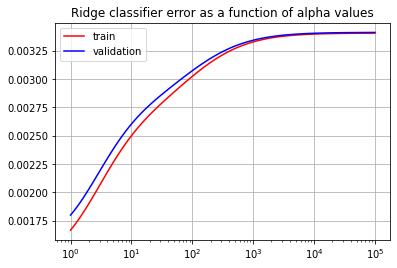

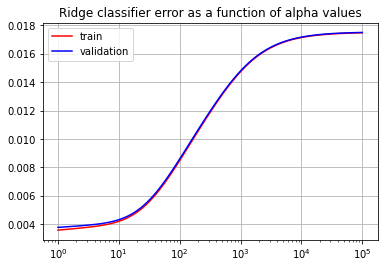

,Train MSE,Validation MSE,Best alpha
Females,0.00166542,0.00179788,1
Males,0.00357682,0.0037711,1


In [30]:
# this is what they mean ?
SexDataFrame2 = pd.DataFrame(columns= ['Train MSE', 'Validation MSE', 'Best alpha'])
SexDataFrame2.loc['Females'] = [0,0,0]
SexDataFrame2.loc['Males'] = [0,0,0]

best_score_on_train_f, best_score_on_validation_f, best_alpha_f = tuning(train_quadratic[train_quadratic['Sex'] == 0], features_list=quad_features)
best_score_on_train_m, best_score_on_validation_m, best_alpha_m = tuning(train_quadratic[train_quadratic['Sex'] == 1], features_list=quad_features)

SexDataFrame2.loc['Females']['Train MSE'], SexDataFrame2.loc['Females']['Validation MSE'], SexDataFrame2.loc['Females']['Best alpha'] = best_score_on_train_f, best_score_on_validation_f, best_alpha_f
SexDataFrame2.loc['Males']['Train MSE'], SexDataFrame2.loc['Males']['Validation MSE'], SexDataFrame2.loc['Males']['Best alpha'] = best_score_on_train_m, best_score_on_validation_m, best_alpha_m

SexDataFrame2

In [31]:
multi_polynomial = MultiRegressor(Ridge(best_alpha_m), Ridge(best_alpha_f))
multi_polynomial

MultiRegressor(h_female=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                              max_iter=None, normalize=False, random_state=None,
                              solver='auto', tol=0.001),
               h_male=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                            max_iter=None, normalize=False, random_state=None,
                            solver='auto', tol=0.001))

**Q18**

In [32]:
multiScoreDF = pd.DataFrame(columns= ['Multilevel Model','Section', 'Sex', 'Train MSE', 'Valid MSE'])
multiScoreDF = multiScoreDF.set_index(["Multilevel Model", "Section", "Sex"])
for gender in ['M', 'F']:
  multiScoreDF.loc['Linear', 4, gender] = [0,0]
  multiScoreDF.loc['Polynomial', 5, gender] = [0,0]
# multiScoreDF

In [33]:
Ridge_males = Ridge(best_alpha_m)
Ridge_females = Ridge(best_alpha_f)

err_train_m ,err_val_m = CV_evaluation(Ridge_males, males[features], males['VariantScore'])
err_train_f ,err_val_f = CV_evaluation(Ridge_females, females[features], females['VariantScore'])

multiScoreDF.loc['Linear', 4, 'M'] = [err_train_m ,err_val_m]
multiScoreDF.loc['Linear', 4, 'F'] = [err_train_f ,err_val_f]

quad_m = train_quadratic[train_quadratic['Sex'] == 1]
quad_f = train_quadratic[train_quadratic['Sex'] == 0]


err_train_m_quad ,err_val_m_quad = CV_evaluation(Ridge_males, quad_m[quad_features], quad_m['VariantScore'])
err_train_f_quad ,err_val_f_quad = CV_evaluation(Ridge_females, quad_f[quad_features], quad_f['VariantScore'])

multiScoreDF.loc['Polynomial', 5, 'M'] = [err_train_m_quad ,err_val_m_quad]
multiScoreDF.loc['Polynomial', 5, 'F'] = [err_train_f_quad ,err_val_f_quad]

multiScoreDF

,,,Train MSE,Valid MSE
Multilevel Model,Section,Sex,,
Linear,4,M,0.00379825,0.00393541
Polynomial,5,M,0.00357682,0.0037711
Linear,4,F,0.00284185,0.00299319
Polynomial,5,F,0.00166542,0.00179788


**Q20**

In [34]:
errors = CV_evaluation(multi_polynomial, train_quadratic[quad_features], train_quadratic['VariantScore'])

errors_data.loc['Multilevel poly']['Train MSE'] = errors[0]
errors_data.loc['Multilevel poly']['Validation MSE'] = errors[1]

errors_data

,section,Train MSE,Validation MSE
Dummy,2,0.0121805,0.01219
Basic Linear,3,0.00739167,0.00756576
Multilevel linear,4,0.00333368,0.00346586
Multilevel poly,5,0.00262943,0.00279333


# Section 6: Testing our models

In [35]:
tmp_arr = [0,0,0,0]
dummy_regressor.fit(train[features], train['VariantScore'])
tmp_arr[0] = mean_squared_error(test['VariantScore'], dummy_regressor.predict(test[features]))

ridge = Ridge(best_alpha)
ridge.fit(train[features], train['VariantScore'])
tmp_arr[1] = mean_squared_error(test['VariantScore'], ridge.predict(test[features]))

multi.fit(train[features], train['VariantScore'])
tmp_arr[2] = mean_squared_error(test['VariantScore'], multi.predict(test[features]))

multi_polynomial.fit(train_quadratic[quad_features], train_quadratic['VariantScore'])
tmp_arr[3] = mean_squared_error(test_quadratic['VariantScore'], multi_polynomial.predict(test_quadratic[quad_features]))

errors_data2 = errors_data.copy()
errors_data2['Test MSE'] = tmp_arr
errors_data2

,section,Train MSE,Validation MSE,Test MSE
Dummy,2,0.0121805,0.01219,0.013121
Basic Linear,3,0.00739167,0.00756576,0.007342
Multilevel linear,4,0.00333368,0.00346586,0.003166
Multilevel poly,5,0.00262943,0.00279333,0.002459


# Section 7: Custom models challenge

In [36]:
def get_top_feat(df, classifier_ctr, alpha, features_list):
  clf = classifier_ctr(alpha)
  clf.fit(df[features_list], df['VariantScore'])
  #print('w = ',clf.coef_)

  top_feat = pd.Series(clf.coef_, index = features_list)
  top_feat = top_feat.apply(lambda x: x if x>0 else -x)
  top_feat = top_feat.sort_values(axis=0)

  # pd.Series(top_feat, index = features).nlargest(30).plot(kind='barh')
  return top_feat, list(top_feat.keys())


def tuning4 (df, classifier_ctr, features_list):
  best_score = 100
  best_alpha = -1000
  for a in range(0,10000,25):
    clf = classifier_ctr(alpha=a/1000)
    ret = CV_evaluation(clf, df[features_list], df['VariantScore'])
    # print("a: " + str(a) + ", score: " + str(ret[1]))
    if ret[1] < best_score:
      best_score = ret[1]
      best_alpha = a/1000
  print("best_score is: " + str(best_score))
  print("best_alpha is: " + str(best_alpha))
  return (best_score, best_alpha)


def tuning_num_of_feat (df, classifier_ctr, alpha, features_list):
  best_score = 100
  best_n = 0
  for n in range(5,len(features_list), 2):
    select_feat = features_list[-1*n:]
    clf = classifier_ctr(alpha)
    ret = CV_evaluation(clf, df[select_feat], df['VariantScore'])
    if ret[1] < best_score:
      best_score = ret[1]
      best_n = n
  print("best_score is: " + str(best_score))
  print("best_n is: " + str(best_n))
  return (best_score, best_n)

quad_features_no_sex = quad_features.copy()
quad_features_no_sex.remove('Sex')
quad_features_no_sex_no_blood = quad_features_no_sex.copy()
quad_features_no_sex_no_blood.remove('BloodType')

In [37]:
def build_clf(df, classifier_ctr, features_list):
  best_multiExtra=0
  feats = features_list
  best_n_feat = 666

  for i in range(1,4):
    tmp, best_multiExtra = tuning4(df, classifier_ctr, feats[-1*best_n_feat:])
    tmp, feats = get_top_feat(df, classifier_ctr, best_multiExtra, feats)
    tmp, best_n_feat = tuning_num_of_feat(df, classifier_ctr, best_multiExtra, feats)

  clf = classifier_ctr(best_multiExtra)
  clf.fit(df[feats[-1*best_n_feat:]], df['VariantScore'])
  return clf, feats[-1*best_n_feat:]

In [38]:
df_m_b0 = quad_m[quad_m['BloodType'] == 0]
df_m_b1 = quad_m[quad_m['BloodType'] == 1]
df_f_b0 = quad_f[quad_f['BloodType'] == 0]
df_f_b1 = quad_f[quad_f['BloodType'] == 1]

clf_m_b0, clf_m_b0_feat = build_clf(df_m_b0, Ridge, quad_features_no_sex_no_blood)
clf_m_b1, clf_m_b1_feat = build_clf(df_m_b1, Ridge, quad_features_no_sex_no_blood)
clf_f_b0, clf_f_b0_feat = build_clf(df_f_b0, Ridge, quad_features_no_sex_no_blood)
clf_f_b1, clf_f_b1_feat = build_clf(df_f_b1, Ridge, quad_features_no_sex_no_blood)

best_score is: 0.0023528268853961385
best_alpha is: 0.025
best_score is: 0.002243811974280723
best_n is: 33
best_score is: 0.002243811974280723
best_alpha is: 0.025
best_score is: 0.002243811974280723
best_n is: 33
best_score is: 0.002243811974280723
best_alpha is: 0.025
best_score is: 0.002243811974280723
best_n is: 33
best_score is: 0.004770275376827941
best_alpha is: 0.075
best_score is: 0.004613521150790292
best_n is: 31
best_score is: 0.004612499862263487
best_alpha is: 0.05
best_score is: 0.004636983106880871
best_n is: 37
best_score is: 0.004636430734328412
best_alpha is: 0.025
best_score is: 0.004622401424733683
best_n is: 33
best_score is: 0.001502768040397068
best_alpha is: 0.05
best_score is: 0.001431773489850589
best_n is: 31
best_score is: 0.0014299215693386834
best_alpha is: 0.025
best_score is: 0.0014391878658668064
best_n is: 33
best_score is: 0.0014391878658668064
best_alpha is: 0.025
best_score is: 0.0014391878658668064
best_n is: 33
best_score is: 0.00178316309414848

In [39]:
def custom_pred(X):
  all_pred = []
  for index, x in X.iterrows():
    y_pred = 666
    if x['Sex'] == 1:
      if x['BloodType'] == 0:
        y_pred = clf_m_b0.predict([x[clf_m_b0_feat]])
      else:
        y_pred = clf_m_b1.predict([x[clf_m_b1_feat]])
    else:
      if x['BloodType'] == 0:
        y_pred = clf_f_b0.predict([x[clf_f_b0_feat]])
      else:
        y_pred = clf_f_b1.predict([x[clf_f_b1_feat]])
    all_pred.append(y_pred[0])
  return all_pred

final_res = mean_squared_error(test_quadratic['VariantScore'], custom_pred(test_quadratic))
print(final_res)

0.002373321689367933


In [40]:
final_res = mean_squared_error(test_quadratic['VariantScore'], custom_pred(df_to_quad_df(test)))
print(final_res)  # used as validation

0.002373321689367933


# Section 8: Submitted model predictions

In [41]:
unlabeled_raw = pd.read_csv('https://raw.githubusercontent.com/sivanyo/ML-HW3/main/variant_unlabeled.csv')
# unlabeled_raw

In [42]:
unlabeled = unlabeled_raw.copy()
preprocessing_data(unlabeled)
# unlabeled

In [43]:
all_df = df_raw.copy()
preprocessing_data(all_df) 
all_df_quad = df_to_quad_df(all_df)

In [44]:
quad_all_m = all_df_quad[all_df_quad['Sex'] == 1]
quad_all_f = all_df_quad[all_df_quad['Sex'] == 0]

df_m_b0 = quad_all_m[quad_all_m['BloodType'] == 0]
df_m_b1 = quad_all_m[quad_all_m['BloodType'] == 1]
df_f_b0 = quad_all_f[quad_all_f['BloodType'] == 0]
df_f_b1 = quad_all_f[quad_all_f['BloodType'] == 1]

clf_m_b0, clf_m_b0_feat = build_clf(df_m_b0, Ridge, quad_features_no_sex_no_blood)
clf_m_b1, clf_m_b1_feat = build_clf(df_m_b1, Ridge, quad_features_no_sex_no_blood)
clf_f_b0, clf_f_b0_feat = build_clf(df_f_b0, Ridge, quad_features_no_sex_no_blood)
clf_f_b1, clf_f_b1_feat = build_clf(df_f_b1, Ridge, quad_features_no_sex_no_blood)

best_score is: 0.0022949749320337535
best_alpha is: 0.05
best_score is: 0.002146857576256953
best_n is: 15
best_score is: 0.0021300694704987485
best_alpha is: 0.0
best_score is: 0.002183415921760066
best_n is: 33
best_score is: 0.002175956905111986
best_alpha is: 0.025
best_score is: 0.0021552485082246037
best_n is: 15
best_score is: 0.004621509734911519
best_alpha is: 0.125
best_score is: 0.004486560489923869
best_n is: 27
best_score is: 0.004481999495049185
best_alpha is: 0.075
best_score is: 0.004487492028838988
best_n is: 29
best_score is: 0.0044872172534046375
best_alpha is: 0.05
best_score is: 0.004501425010104398
best_n is: 33
best_score is: 0.001563353190056082
best_alpha is: 0.1
best_score is: 0.0015220574587977186
best_n is: 31
best_score is: 0.0015207692596644028
best_alpha is: 0.075
best_score is: 0.0015226963050810434
best_n is: 31
best_score is: 0.0015226963050810434
best_alpha is: 0.075
best_score is: 0.0015226963050810434
best_n is: 31
best_score is: 0.00157847064394134

In [45]:
pred_unlabeled = pd.DataFrame(index=np.arange(unlabeled.shape[0]), columns = ['ID', 'VariantScore'])
pred_unlabeled['ID'] = unlabeled['ID']
unlabeled_quad = df_to_quad_df(unlabeled)


ridge = Ridge(tuning(all_df, features, print_flag=False)[2])
ridge.fit(all_df[features], all_df['VariantScore'])
pred_unlabeled['VariantScore'] =  ridge.predict(unlabeled[features])
pred_unlabeled.to_csv("pred_3.csv", index=False)
files.download("pred_3.csv")


multi = MultiRegressor(Ridge(best_alpha_m), Ridge(best_alpha_f))
multi.fit(all_df[features], all_df['VariantScore'])
pred_unlabeled['VariantScore'] =  multi.predict(unlabeled[features])
pred_unlabeled.to_csv("pred_4.csv", index=False)
files.download("pred_4.csv")


multi_quad = MultiRegressor(Ridge(tuning(all_df_quad[all_df_quad['Sex'] == 1], features_list=quad_features, print_flag=False)[2]), Ridge(tuning(all_df_quad[all_df_quad['Sex'] == 0], print_flag=False, features_list=quad_features)[2]))
multi_quad.fit(all_df_quad[quad_features], all_df_quad['VariantScore'])
pred_unlabeled['VariantScore'] =  multi_quad.predict(unlabeled_quad[quad_features])
pred_unlabeled.to_csv("pred_5.csv", index=False)
files.download("pred_5.csv")


pred_unlabeled['VariantScore'] = custom_pred(unlabeled_quad)
pred_unlabeled.to_csv("pred_7.csv", index=False)
files.download("pred_7.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# טיוטה

In [46]:
# # this is to make sure we predicing unlabeled as we want to (check by trying the same proccess on test)
# unlabeled = test.copy()
# unlabeled.drop('VariantScore', axis=1, inplace=True)
# pred_unlabeled = pd.DataFrame(index=np.arange(unlabeled.shape[0]), columns = ['ID', 'VariantScore'])
# pred_unlabeled['ID'] = unlabeled['ID']
# unlabeled_quad = df_to_quad_df(unlabeled)

# ridge = Ridge(tuning(all_df, features, print_flag=False)[2])
# ridge.fit(all_df[features], all_df['VariantScore'])
# pred_unlabeled['VariantScore'] =  ridge.predict(unlabeled[features])
# pred_unlabeled.to_csv("pred_3.csv", index=False)
# # files.download("pred_3.csv")
# print("score3: ", mean_squared_error(pred_unlabeled['VariantScore'], test['VariantScore']))

# multi = MultiRegressor(Ridge(best_alpha_m), Ridge(best_alpha_f))
# multi.fit(all_df[features], all_df['VariantScore'])
# pred_unlabeled['VariantScore'] =  multi.predict(unlabeled[features])
# pred_unlabeled.to_csv("pred_4.csv", index=False)
# # files.download("pred_4.csv")
# print("score4: ", mean_squared_error(pred_unlabeled['VariantScore'], test['VariantScore']))

# multi_quad = MultiRegressor(Ridge(tuning(all_df_quad[all_df_quad['Sex'] == 1], features_list=quad_features, print_flag=False)[2]), Ridge(tuning(all_df_quad[all_df_quad['Sex'] == 0], print_flag=False, features_list=quad_features)[2]))
# multi_quad.fit(all_df_quad[quad_features], all_df_quad['VariantScore'])
# pred_unlabeled['VariantScore'] =  multi_quad.predict(unlabeled_quad[quad_features])
# pred_unlabeled.to_csv("pred_5.csv", index=False)
# # files.download("pred_5.csv")
# print("score5: ", mean_squared_error(pred_unlabeled['VariantScore'], test_quadratic['VariantScore']))

# pred_unlabeled['VariantScore'] = custom_pred(unlabeled_quad)
# pred_unlabeled.to_csv("pred_7.csv", index=False)
# # files.download("pred_7.csv")
# print("score7: ", mean_squared_error(pred_unlabeled['VariantScore'], test_quadratic['VariantScore']))
